## Approach

* This is a simplied version of YOLO. The input image is 512x512. YOLO was intended to train on images which all contained at least one object, most multiple objects. The architecture and loss functions have been adapted for this case, where not every image contains an object and there are at most 4 ROIs per image. 
* Since the maximum number of ROIs in each image is 4 we decided to use a 2x2 grid to simplify the network. In the case where multiple ROIs occur in the same cell we combine the ROIs into a single ROI by expanding the box to include both. Each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
    * We have removed the entire classification section, using the confidence to indicate whether there is an ROI in the cell instead.
* A sigmoid is applied to the output of the network to result in values between 0 and 1    
* The x and y coordinates are offsets from the upper left corner of each cell, the w and h are percentage of the total width.
* The loss function is based on YOLO with some differences:
    * The weights of the components have been updated
    * The classification loss has been removed.
    * The "objectness" loss of YOLO tries to make the confidence match the actual IOU. Since our model only outputs one box per cell, this doesn't really make any sense and ends up driving the confidence down to the IOU. We replace this by an IOU loss which subtracts the IOU for that cell from 1.

## Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* There are two dilated convolutions at the end of the network to provide context.
* The dilated convolutions are followed by two strided convolutions which downsize to 2x2.
* Finally there are a series of 1x1 convolutions which output a 2x2x5 tensor.
* We are using an Adam optimizer with gradient clipping to avoid exploding gradients, which had been a problem.

## Predictions
* To generate our predictions we loop through each cell of the output
* We unnormalize the output to get the actual values
* If the confidence is greater than 0.5 and the box has width and height we append it to the list of candidates.
* We apply non-max suppression to remove duplicates.
* The remaining boxes are concatenated onto the output string.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.
* v6 - centering input data so maybe bboxes can be output more accurately? Also centering the image
* v6.2 - labels have ROI centered in center of cell by default instead of mean location.
* v8 - using custom loss function based on YOLO loss. Set default height and width to 1 px because 0 sent the gradients to -inf which screwed everything up.
* v10 - using 2x2 grid as output
* v12 - changing layout of model slightly - replaced final pools with convs with strides; reduced number of params; ensure that there is at least one positive image per batch.
* v13 - tweaking architecture slightly.
* v14 - going to 5x5 grid
* v15 - downsizing with average and max pool followed by 1x1 convolutions
* v15.2 - fixed an error where a layer of the network was being bypassed, removed some layers to prevent overfitting, training on labels with jittered ROIs
* v18 - separating fc branches for confidence and boxes, might work better?

In [1]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip install -q pydicom 
!pip install -q imgaug 
!pip install -q kaggle
!pip install -q tqdm 

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


^C


You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
from skimage.filters import gaussian
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

c:\users\eric\anaconda2\envs\hse_dl\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
        'mimeType': 'application/octet-stream',
     }

    media = MediaFileUpload(path, 
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick]#.astype("int")

# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

# sigmoid in numpy, with limit to avoid nans                             
def sigmoid(x):
    # to avoid NaNs set a lower floor on x values
    y = np.maximum(x, -700)
    y = np.minimum(y, 700)
    return 1 / (1 + np.exp(-y))    

# adjust contrast of image
def change_contrast(img, contrast_factor):
    mean = np.mean(img)
    img = (img - mean) * contrast_factor + mean
    return img

def get_intersect(box1, box2):
    # unpack each box
    x1, y1, w1, h1, c1 = box1
    x2, y2, w2, h2, x2 = box2
    
    # get the far corners
    x1_f = x1 + w1
    y1_f = y1 + h1
    x2_f = x2 + w2
    y2_f = y2 + h2
    
    # get corners of intersection
    x1_i = np.maximum(x1, x2)
    y1_i = np.maximum(y1, y2)
    x2_i = np.minimum(x1_f, x2_f)
    y2_i = np.minimum(y1_f, y2_f)
    
    w_i = x2_i - x1_i
    h_i = y2_i - y1_i
    
    w_i = np.maximum(w_i, 0)
    h_i = np.maximum(h_i, 0)

    intersect_area = w_i * h_i
    
    return intersect_area  
  
# helper function to calculate IoU
def calculate_iou(box1, box2):
    x11, y11, w1, h1 = box1[:4]
    x21, y21, w2, h2 = box2[:4]
    assert w1 * h1 > 0
    assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union  

# calculate IOU where there can be multiple overlapping truths and predictions
def calc_iou_better(y_true, y_pred):
    label_array = np.zeros((1024, 1024))
    
    for truth in y_true:
      x,y,w,h = truth[:4].astype(int)  
      label_array[y:y+h, x:x+w] = 1
                
    pred_array = np.zeros((1024, 1024))
    for pred in y_pred:
      x,y,w,h = pred[:4].astype(int)

      # update the pixels
      pred_array[y:y+h, x:x+w] = 1
                
    true_area = np.sum(label_array)
    pred_area = np.sum(pred_array)
    
    intersect_area = np.sum((pred_array == 1) & (label_array == 1))
    
    union = true_area + pred_area - intersect_area
    
    iou = intersect_area / (union + 1e-6)
    
    return iou      
      
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None
    elif (len(boxes_true) == 0) and (len(boxes_pred) != 0):
        return 0
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = calculate_iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)      

In [5]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [6]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
if not os.path.exists("./stage_1_detailed_class_info.csv.zip"):
    !kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 37.3kB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 85.4MB/s]
  0% 0.00/51.8k [00:00<?, ?B/s]
100% 51.8k/51.8k [00:00<00:00, 40.3MB/s]
  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 84.8MB/s]
 96% 121M/126M [00:01<00:00, 80.2MB/s]
100% 126M/126M [00:01<00:00, 96.4MB/s]
100% 3.16G/3.17G [00:37<00:00, 94.2MB/s]
100% 3.17G/3.17G [00:38<00:00, 89.5MB/s]


In [7]:
# unzipping takes a few minutes
if not os.path.exists("./stage_1_train_labels.csv"):
    print("Unzipping...")
    !unzip -q -o stage_1_test_images.zip -d stage_1_test_images
    !unzip -q -o stage_1_train_images.zip -d stage_1_train_images
    !unzip -q -o stage_1_train_labels.csv.zip

Unzipping...


# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [4]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [5]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp gs://{bucket_name}/yolo_labels_centered_5x5_10a.p ./yolo_labels_centered_5x5_10a.p

Updated property [core/project].
Your credentials are invalid. Please run
$ gcloud auth login


In [6]:
with open('yolo_labels_centered_5x5_10a.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [7]:
random.seed(1702)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.15)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 451
n valid samples 79


In [8]:
positive_images = []

for filename in pneumonia_locations:
    label = pneumonia_locations[filename][...,0]
    if np.max(label) > 1e-6:
        if filename + ".dcm" in train_filenames:
            positive_images.append(filename + ".dcm")

 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [9]:
BATCH_SIZE = 16
IMAGE_SIZE = 480
GRID_SIZE = 5
CELL_SIZE = 1024 / GRID_SIZE
CHECKPOINT_PATH = "yolo18_1_480.h5"

In [14]:
!gsutil cp gs://{bucket_name}/{CHECKPOINT_PATH} ./{CHECKPOINT_PATH}

Copying gs://pneumonia/yolo18_1_480.h5...
- [1 files][ 54.6 MiB/ 54.6 MiB]                                                
Operation completed over 1 objects/54.6 MiB.                                     


In [10]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
    
    def augment_imgs(self, img, confs, boxes):
        # flip the image half the time
        if random.random() > 0.5:
            img = np.fliplr(img)
            
            # update our x coords
            mask = (confs != 0)
            
            # flip
            boxes[mask, 0] = (1 - boxes[mask,0])
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=1)   
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=1)            
        
        # slight shape skew
        if random.random() > 0.5:
            x_scale = np.random.uniform(low=0.96, high=1.04, size=None)
            y_scale = np.random.uniform(low=0.96, high=1.04, size=None)
            
            # resize the image
            img = resize(img, (int(1024 * y_scale), int(1024 * x_scale)), mode='reflect')
            
            # resize the boxes
            boxes[...,2] = (boxes[...,2] * x_scale)
            boxes[...,3] = (boxes[...,3] * y_scale)
         
        # adjust contrast or contrast
        if random.random() > 0.5:  
            if random.random() > 0.5:  
                factor = np.random.uniform(low=0.85, high=1.15)
                img = img * factor
            else:
                # generate a random contrast adjustment
                contrast_factor = np.random.normal(loc=1.0, scale=0.10)

                # put some limits on the contrast
                contrast_factor = np.minimum(contrast_factor, 1.25)
                contrast_factor = np.maximum(contrast_factor, 0.75)

                # adjust the image
                img = change_contrast(img, contrast_factor)

        # gaussian blur
        if random.random() > 0.5:
            sigma = np.random.uniform(low=0, high=1.25)
            img = gaussian(img, sigma=sigma)
        
        # small shifts
        if random.random() > 0.5:  
            ## small random shifts
            h_offset = np.random.randint(low=0, high=5)
            v_offset = np.random.randint(low=0, high=5)

            # crop the images
            img = img[v_offset:,h_offset:]
        
        return img, confs, boxes
            
            
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes because they will be flipped separately
        # round the confidences since some are 0.99 or maybe even 1e-6
        confs = np.round(label[:,:,0])
        boxes = label[:,:,1:]
        
        ## augment the data with flips, small shifts and contrast adjustment
        if self.augment:
            img, confs, boxes = self.augment_imgs(img, confs, boxes)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        # scale and center the image
        img = (img - np.mean(img)) / np.max(img)
        
        boxes = np.concatenate([confs.reshape((GRID_SIZE,GRID_SIZE,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            bboxes = np.array(bboxes)
            
            # make sure there is at least one positive image in the batch
            pos = np.max(bboxes[:,:,:,0])
            if pos < 1:
                # pick a random positive image
                filename = np.random.choice(positive_images)
                img, label = self.__load__(filename)
                
                # add the positive image to our batch
                imgs[-1] = img
                bboxes[-1] = label
                
            labels = bboxes
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [11]:
test_images = ["efbaaa0c-da33-4200-a62e-d7d9d48c58ac.dcm", "15de0e36-aad2-49f5-b797-dba25cc0c500.dcm",
#               "bc87d74c-9d22-4046-ae17-5891adfa0b41.dcm", "3a7cb9dd-169c-467e-a5f7-c179a6459d80.dcm",
              ]
train_gen = generator(folder, test_images, pneumonia_locations, batch_size=2, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)

C:\Users\eric\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


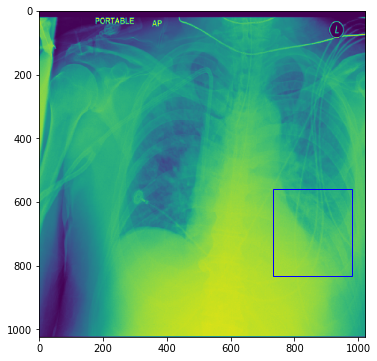

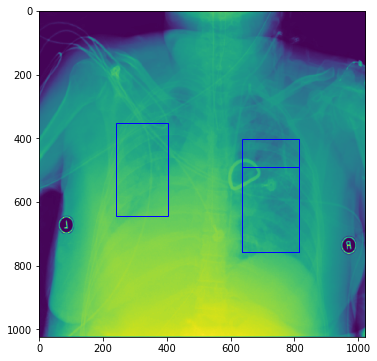

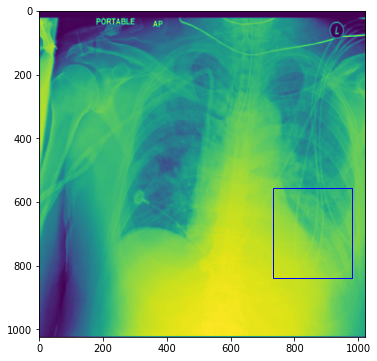

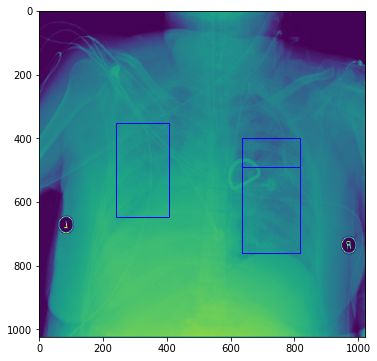

In [13]:
counter = 0
for imgs, labels in train_gen:
    
    for img, label in zip(imgs, labels):
        f, ax = plt.subplots(figsize=(6, 6))
        
        # resize the image
        img = resize(img, (1024, 1024), mode='reflect')
        
        # display the image
        plt.imshow(np.squeeze(img))
        
        # add the labels
        if np.sum(label[...,0]) > 0:
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    if label[i,j,0] > 0.5:
                        # unpack the data
                        x,y,w,h = label[i,j,1:]
                        
                        # unnormalize the data
                        w,h = w*1024, h*1024
                        x = unnorm(x, j, CELL_SIZE)
                        y = unnorm(y, i, CELL_SIZE)
                        
                        # get the corners
                        x = x - (w / 2)
                        y = y - (h / 2)
                        
                        # draw the box
                        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                        ax.add_patch(rect)
            
        plt.show()
    
    counter+= 1
    if counter > 1:
        break

In [45]:
def plot_image(img, label, preds):
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(np.squeeze(img))
    
    label_array = np.zeros((1024, 1024))
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if label[i,j,0] > 0.5:
                # unpack the data
                x,y,w,h = label[i,j,1:]

                # unnormalize the data
                w,h = int(w*1024), int(h*1024)
                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)

                # get the corners
                x = int(x - (w / 2))
                y = int(y - (h / 2))
                
                # draw the box
                rect = patches.Rectangle((x,y),w,h,linewidth=3,edgecolor='b',facecolor='none')
                ax.add_patch(rect)
                
                # update the pixels
                label_array[y:y+h, x:x+w] = 1
                
    pred_array = np.zeros((1024, 1024))
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if preds[i,j,0] > 0.5:
                # unpack the data
                x,y,w,h = preds[i,j,1:]

                # unnormalize the data
                w,h = int(w*1024), int(h*1024)
                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)

                # get the corners
                x = int(x - (w / 2))
                y = int(y - (h / 2))

                # draw the box
                rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
                
                # update the pixels
                pred_array[y:y+h, x:x+w] = 1
                
    plt.show()
    plt.imshow(pred_array)

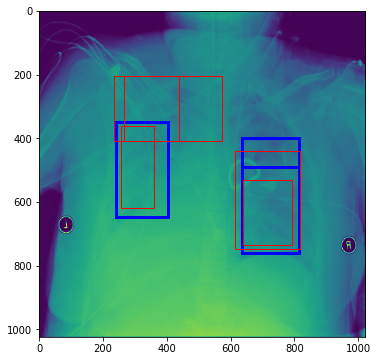

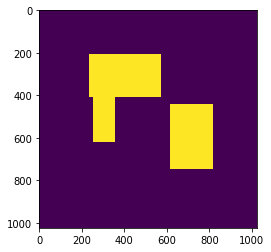

In [56]:
plot_image(img, label, pred)

In [65]:
# calculate IOU where there can be multiple overlapping truths and predictions
def calc_iou_better(y_true, y_pred):
    label_array = np.zeros((1024, 1024))
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if y_true[i,j,0] > 0.5:
                # unpack the data
                x,y,w,h = y_true[i,j,1:]

                # unnormalize the data
                w,h = int(w*1024), int(h*1024)
                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)

                # get the corners
                x = int(x - (w / 2))
                y = int(y - (h / 2))
                
                # update the pixels
                label_array[y:y+h, x:x+w] = 1
                
    pred_array = np.zeros((1024, 1024))
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if y_pred[i,j,0] > 0.5:
                # unpack the data
                x,y,w,h = y_pred[i,j,1:]

                # unnormalize the data
                w,h = int(w*1024), int(h*1024)
                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)

                # get the corners
                x = int(x - (w / 2))
                y = int(y - (h / 2))

                # update the pixels
                pred_array[y:y+h, x:x+w] = 1
                
    true_area = np.sum(label_array)
    pred_area = np.sum(pred_array)
    
    intersect_area = np.sum((pred_array == 1) & (label_array == 1))
    
    union = true_area + pred_area - intersect_area
    
    iou = intersect_area / (union + 1e-6)
    
    return iou

In [66]:
calc_iou_better(label, pred)

True area: 114115.0
Pred area: 153000.0
Intersect: 86781
Iou: 0.4812237292996261


In [55]:
pred[2,3,:] = [0.95, 0.5, 0.9, 0.2, 0.3]

# Network

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x_1 = keras.layers.MaxPool2D(2)(x)
    x_2 = keras.layers.AveragePooling2D(2)(x)
    x = keras.layers.concatenate([x_1, x_2])
    x = keras.layers.Conv2D(channels, 1, padding="same", use_bias=False)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 512x512x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # downsample to 256x256x24
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # residual blocks
    for d in range(depth):
        
        x = create_downsample(channels, x)
        channels = channels * 2
        
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    x_2 = x
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # dilated convolutions for context - 15x15x512
    x = keras.layers.Conv2D(channels, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, (3,3), padding='same', strides=(1,1), activation=None, name="last_conv")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Dropout(0.15)(x)
    
    # downsample to 8x8 with stride 2
    x = keras.layers.Conv2D(768, (3,3), padding='same', strides=(3,3), activation=None, name="downsample_1", kernel_regularizer=keras.regularizers.l2(l=0.002))(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Dropout(0.15)(x)
    
    # confidence output branch
    c = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_c", kernel_regularizer=keras.regularizers.l2(l=0.005))(x)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.10)(c)
    
    confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation="linear", name="confidence_output")(c)
    
    # bounding box branch
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.005))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.25)(b)
    
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.003))(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    
    boxes = keras.layers.Conv2D(4, (1,1), padding='same', activation="linear")(b)
    boxes = keras.layers.concatenate([confidence, boxes], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=boxes)
    
    return model

# Train network


In [0]:
# after each epoch run our function to calculate the actual IOU for half of the validation images. 
# I was not able to figure out how to implement this in tensorflow since I don't think we can iterate
# through tensors. So we do it as a callback instead. Hopefully this will approximate the actual IOU score.
class Calc_IOU_CB(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        valid_gen2 = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=IMAGE_SIZE, shuffle=True, predict=False)
        ious = []
        tps = 0
        fps = 0
        fns = 0
        
        counter = 0
        for imgs, labels in valid_gen2:
            preds = self.model.predict(imgs)
            
            # calculate the IOU
            iou = overlap_iou2(labels, preds)
            ious.append(iou)
            
            # calculate the precision and recall
            tp, fp, fn = calc_tps(labels, preds)
            
            tps += tp
            fps += fp
            fns += fn
            
            counter += BATCH_SIZE
            
            if counter > 900:
                break
        
        prec = tps / (tps + fps)
        recall = tps / (tps + fns)
        f1_score = 2 * (prec * recall) / (prec + recall)
        print("Epoch", epoch, ": Mean IOU:", np.mean(ious), "Precision:", prec, "Recall:", recall, "F1:", f1_score)
        
        return
      
# count the true pos, false pos and false negatives so we can calculate precision and recall
def calc_tps(y_true, y_pred):
    true_confs = np.round(y_true[...,0])
    pred_confs = np.round(sigmoid(y_pred[...,0]))
    
    tps = np.sum((pred_confs == 1) & (true_confs == 1))
    fps = np.sum((pred_confs == 1) & (true_confs != 1))
    fns = np.sum((pred_confs != 1) & (true_confs == 1))
    
    return tps, fps, fns      

In [21]:
GRID_SIZE = 5
CELL_SIZE = 1024 / GRID_SIZE

# calculate f1 score with smoothing to avoid NaNs
def f1_score(y_true, y_pred):
  # apply sigmoid and round our labels
  y_pred = tf.round(tf.sigmoid(y_pred[...,0]))
  y_true = tf.round(y_true[...,0])
  
  tps = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, 1), tf.equal(y_true, 1)), dtype=tf.int16)) + 1
  fps = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, 1), tf.equal(y_true, 0)), dtype=tf.int16)) + 1
  fns = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, 0), tf.equal(y_true, 1)), dtype=tf.int16)) + 1
  
  precision = tps / (tps + fps)
  recall = tps / (tps + fns)
  
  f1_score = 2 * (precision * recall) / (precision + recall)
  
  return f1_score

def binary_accuracy(y_true, y_pred):
    # apply sigmoid to our predictions
    y_pred = tf.sigmoid(y_pred)
    # round both since our negative truths are 1e-16 instead of 0
    y_true = tf.round(tf.reshape(y_true, [-1, 5]))
    y_pred = tf.round(tf.reshape(y_pred, [-1, 5]))
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true[:,0], y_pred[:,0]), dtype=tf.float32))
    return acc

def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    y_pred = tf.sigmoid(y_pred)
    
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # uncenter the data - make sure the numbers are positive
    x11 = x11 * CELL_SIZE
    x21 = x21 * CELL_SIZE
    y11 = y11 * CELL_SIZE
    y21 = y21 * CELL_SIZE
    
    w1 = w1 * 1024
    w2 = w2 * 1024
    h1 = h1 * 1024
    h2 = h2 * 1024
    
    # is there either a box predicted here or a box actually here?
    mask = (pred_conf >= 0.5) | (true_boxes == 1)
    
    # get the far corners of the boxes
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    # get the area of each box
    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area + 1
    
    iou = tf.maximum(inter_area/(union + 1e-6), 0)
    
    # apply the mask
    iou = tf.boolean_mask(iou, mask)
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(iou)

def overlap_iou2(y_true, y_pred):
    """
    Args:
        y_true and y_pred - arrays of boxes containing center points, h and w of boxes
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Average IOU over boxes
    """
    OVERLAP = 0.3
    
    # apply the sigmoid
    y_pred = sigmoid(y_pred)
    
    ious = []
    
    # loop over both sets of boxes
    for truth, pred in zip(y_true, y_pred):
        # get true area
        true_area = 0
        true_boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = truth[i,j,:]
                # if we have an ROI
                if c == 1:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    true_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    true_boxes.append([x, y, x+w, y+h])
                    
        pred_area = 0
        pred_boxes = []
        # get the predicted area
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                c, x, y, w, h = pred[i,j,:]
                # if we have an ROI
                if c > 0.5:
                    # unnormalize the data
                    w, h = w*1024, h*1024
                    pred_area += w * h
                    
                    # unnormalize the x and y
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    pred_boxes.append([x, y, x+w, y+h])
            
        intersect_area = 0
        
        # non-max suppression?
        pred_boxes = non_max_suppression_fast(np.array(pred_boxes), OVERLAP)
        
        # get the intersection
        for pred_box in pred_boxes:
            x1_p, y1_p, x2_p, y2_p = pred_box
            
            for true_box in true_boxes:
                x1_t, y1_t, x2_t, y2_t = true_box
                
                # if the boxes overlap at all
                if (x1_p >= x1_t and y1_p >= y1_t) or (x1_p <= x1_t and y1_p <= y1_t):
                    # get the intersection corners
                    x1_i = np.maximum(x1_p, x1_t)
                    y1_i = np.maximum(y1_p, y1_t)
                    x2_i = np.minimum(x2_p, x2_t)
                    y2_i = np.minimum(y2_p, y2_t)
                    
                    # get area of intersect
                    i_w, i_h = x2_i - x1_i, y2_i - y1_i

                    # trap for negative numbers
                    i_w = np.maximum(i_w, 0)
                    i_h = np.maximum(i_h, 0)

                    intersection = i_w * i_h
                    intersect_area += intersection

        union = true_area + pred_area - intersect_area
        
        iou = intersect_area / (union + 1e-16)
        
        # only count the IOU if there are truths or predictions
        if len(true_boxes) or len(pred_boxes):
            ious.append(iou)
    
    iou_area = np.mean(ious)
    return iou_area
                    
def loss_fn(y_true, y_pred):
    # get the iou loss
    iou_loss = iou_loss_fn(y_true, y_pred)
    
    # get the xe loss
    xe_loss = binary_cross_entropy(y_true, y_pred)
    
    # get the box loss
    box_loss = adj_mse(y_true, y_pred)
    
    # add the losses and return them
    return (1.5 * xe_loss) + (box_loss * 2.0) + (iou_loss * 1.0)

# only apply mse to layers with high confidence that there is an ROI or if there actually is an ROI
def adj_mse(y_true, y_pred):
    # coefficients
    lam_coord = 5
    lam_noobj = 0.5
    
    y_pred = tf.sigmoid(y_pred)
        
    # flatten the inputs
    y_true = tf.reshape(y_true, (-1, 5))
    y_pred = tf.reshape(y_pred, (-1, 5))

    # separate the confidence from the boxes
    conf_true, x_true, y_true, w_true, h_true = tf.split(y_true, 5, axis=1)
    conf_pred, x_pred, y_pred, w_pred, h_pred = tf.split(y_pred, 5, axis=1)

    # center squared error
    center_se = tf.square(x_true - y_pred) + tf.square(y_true - y_pred)
    size_se =  tf.square(tf.sqrt(w_true) - tf.sqrt(w_pred)) + tf.square(tf.sqrt(h_true) - tf.sqrt(h_pred))
    
    box_se = center_se + size_se
    
    # only get loss for boxes which are actually positive
    mask = tf.greater(conf_true, 0.5)
    box_se = tf.boolean_mask(box_se, mask)
    
    # weight the loss higher
    box_se = tf.multiply(box_se, 5.0)
    
    loss = tf.reduce_sum(box_se)
    
    return loss
    
# use weight of 0.5 for negative cells, 19 for positive ones
def binary_cross_entropy(y_true, y_pred):
    conf_true = tf.round(y_true[...,0])
    conf_pred = tf.sigmoid(y_pred[...,0])
    
    weight = 18.0
    weights = tf.multiply(conf_true, weight) + 0.5
    
    xe = tf.multiply(tf.square(conf_true - conf_pred), weights)
    
    return tf.reduce_sum(xe)

def objectness_loss_fn(y_true, y_pred):
    y_pred = tf.sigmoid(y_pred)
    
    # pred box conf
    pred_box_conf = y_pred[...,0]
    
    # separate the x, y from the w, h
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16)
    
    true_box_conf = iou_scores * y_true[..., 0]
    
    conf_mask  = tf.zeros_like(iou_scores)
    conf_mask = conf_mask + tf.cast((iou_scores < 0.6), dtype=tf.float32) * (1 - y_true[...,0])
    conf_mask = conf_mask + y_true[..., 0] * 5.0
    
    nb_conf_box  = tf.reduce_sum(tf.cast((conf_mask > 0.0), dtype=tf.float32)) 
    
    loss_conf  =  tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box + 1e-6) / 2.
    
    return tf.reduce_sum(loss_conf)

def iou_loss_fn(y_true, y_pred):
    # apply sigmoid to predictions
    y_pred = tf.sigmoid(y_pred)
    
    # separate the x, y from the w, h and unnormalize them
    true_box_xy = y_true[...,1:3] * CELL_SIZE
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * CELL_SIZE
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # get the area of the boxes
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    # calculate the IOU
    union_areas = pred_areas + true_areas - intersect_areas
    # multiple the IOU by the confidence so we have a more useful loss function
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16) * y_pred[...,0]
    
    # only use the IOU from boxes which actually have ROIs
    mask = tf.greater(y_true[...,0], 0.5)
    use_iou = tf.boolean_mask(1 - iou_scores, mask)
    
    return tf.reduce_sum(use_iou)
    
# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-7, clipnorm=2.0, clipvalue=0.75)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[binary_accuracy, overlap_iou, adj_mse, binary_cross_entropy])

# cosine learning rate annealing
def exp_decay(x):
    lr0 = 0.004
    epochs_drop = 10
    drop = 0.85
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
calc_iou = Calc_IOU_CB()

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 480, 480, 1)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 240, 240, 24) 216         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 240, 240, 24) 96          conv2d_25[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_31 (LeakyReLU)      (None, 240, 240, 24) 0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
conv2d_26 

In [0]:
model.load_weights(CHECKPOINT_PATH)

In [0]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=20, shuffle=True, verbose=1, initial_epoch=6)

Epoch 7/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1363/1364 [============================>.] - ETA: 0s - loss: 83.5735 - binary_accuracy: 0.8989 - overlap_iou: 0.0926 - adj_mse: 8.3634 - binary_cross_entropy: 37.6418
Epoch 00007: saving model to yolo18_1_480.h5
Epoch 6 : Mean IOU: 0.05440114642227619 Precision: 0.38779527559055116 Recall: 0.5377616014558689 F1: 0.45062905070529924
1364/1364 [==============================] - 1295s 949ms/step - loss: 83.5412 - binary_accuracy: 0.8990 - overlap_iou: 0.0927 - adj_mse: 8.3639 - binary_cross_entropy: 37.6204 - val_loss: 137.0480 - val_binary_accuracy: 0.9674 - val_overlap_iou: 0.1978 - val_adj_mse: 8.7286 - val_binary_cross_entropy: 71.9211
Epoch 8/20
1363/1364 [============================>.] - ETA: 0s - loss: 82.7006 - binary_accuracy: 0.9017 - overlap_iou: 0.0950 - adj_mse: 8.3433 - binary_cross_entropy: 37.1331
Epoch 00008: saving model to yolo18_1_480.h5
Epoch 7 : Mean IOU: 0.02847442864563218 Precision: 0.19169394435351883 Recall: 0.8549270072992701 F1: 0.31316844919786097
1364/1364 

In [0]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint, calc_iou], epochs=30, shuffle=True, verbose=1, initial_epoch=20)

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

In [0]:
model.metrics_names

['loss', 'binary_accuracy', 'overlap_iou', 'adj_mse', 'binary_cross_entropy']

In [0]:
def get_intersect(box1, box2):
    # unpack each box
    x1, y1, w1, h1, c1 = box1
    x2, y2, w2, h2, x2 = box2
    
    # get the far corners
    x1_f = x1 + w1
    y1_f = y1 + h1
    x2_f = x2 + w2
    y2_f = y2 + h2
    
    # get corners of intersection
    x1_i = np.maximum(x1, x2)
    y1_i = np.maximum(y1, y2)
    x2_i = np.minimum(x1_f, x2_f)
    y2_i = np.minimum(y1_f, y2_f)
    
    w_i = x2_i - x1_i
    h_i = y2_i - y1_i
    
    w_i = np.maximum(w_i, 0)
    h_i = np.maximum(h_i, 0)

    intersect_area = w_i * h_i
    
    return intersect_area

In [0]:
mses = []
problem_names = []

# find which images are causing the high mse loss
for filename in valid_filenames[:20]:    
    # load and resize the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    
    # get the label
    filename = filename.split('.')[0]
    label = pneumonia_locations[filename]
    # predict the image
    loss = model.evaluate(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1), label.reshape(1, GRID_SIZE, GRID_SIZE, 5), verbose=0)
    mses.append(loss[3])
    if loss[3] > 10:
        print(filename, "Score:", loss)
        problem_names.append(filename + ".dcm")

Pred: 1 1 conf: 0.9098578 194 168 243 340
Pred: 2 1 conf: 0.94163036 198 323 238 310
Pred: 2 3 conf: 0.8652477 592 336 237 282
True: 0 Pred: 116680.09472846985 Intersect: 0
IOU: 0.0
Map IOU: 0


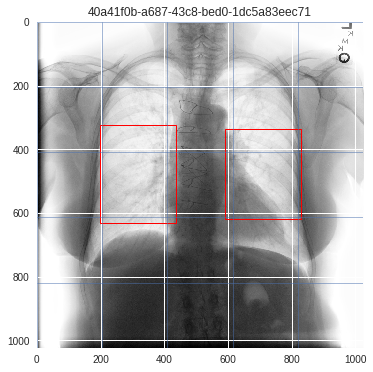

Truth: 1 2 320 275 256 248
Truth: 1 3 648 246 332 306
Truth: 1 4 678 246 302 306
Truth: 2 2 320 275 256 332
Truth: 2 3 648 247 332 604
Truth: 2 4 656 247 332 604
Truth: 3 3 648 397 332 454
Truth: 3 4 678 397 302 454
Pred: 1 1 conf: 0.9669699 227 151 246 367
Pred: 1 2 conf: 0.9649927 344 110 239 338
Pred: 1 3 conf: 0.9486077 619 158 243 348
Pred: 2 1 conf: 0.9535785 236 334 235 328
Pred: 2 2 conf: 0.9374171 320 281 248 314
Pred: 2 3 conf: 0.9264776 629 343 233 316
Pred: 3 1 conf: 0.7684063 228 563 225 269
Pred: 3 2 conf: 0.86740553 347 507 245 288
Pred: 3 3 conf: 0.87499493 586 534 239 277
True: 1031376 Pred: 569171.1479476094 Intersect: 1024050.0
IOU: 1.7763314244380037
Map IOU: 0.008333333333333333


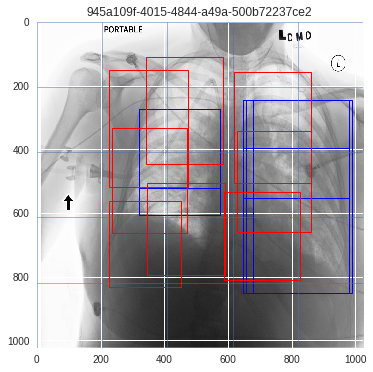

Truth: 3 1 246 665 193 227
Pred: 1 1 conf: 0.7647552 197 185 233 301
Pred: 2 1 conf: 0.9454584 207 355 239 335
Pred: 2 2 conf: 0.9465801 425 335 234 332
Pred: 2 3 conf: 0.893345 588 354 231 308
Pred: 3 1 conf: 0.9382685 199 525 239 306
Pred: 3 2 conf: 0.9122402 402 507 242 324
Pred: 3 3 conf: 0.89920086 581 531 239 288
True: 43811 Pred: 390127.84111368656 Intersect: 42867.0
IOU: 0.10961413094283291
Map IOU: 0.0


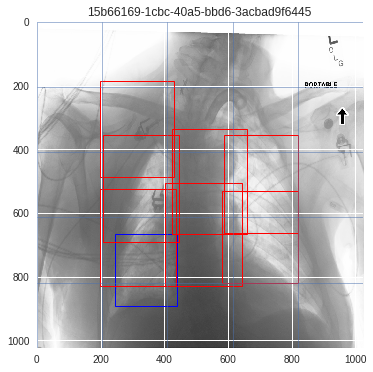

Pred: 1 1 conf: 0.924792 201 165 241 336
Pred: 1 2 conf: 0.917289 397 167 241 333
Pred: 1 3 conf: 0.7953653 596 182 233 301
Pred: 2 1 conf: 0.95658034 214 331 236 325
Pred: 2 2 conf: 0.9529117 432 337 234 327
Pred: 2 3 conf: 0.92075455 609 343 234 309
Pred: 3 1 conf: 0.9298397 182 519 242 296
Pred: 3 2 conf: 0.9258128 397 521 241 299
Pred: 3 3 conf: 0.8713982 571 530 241 274
True: 0 Pred: 493690.4821127057 Intersect: 0
IOU: 0.0
Map IOU: 0


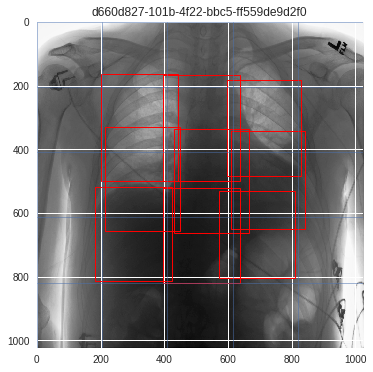

Pred: 1 1 conf: 0.9362777 200 167 245 352
Pred: 1 2 conf: 0.88478327 405 151 234 314
Pred: 1 3 conf: 0.8819941 603 164 237 318
Pred: 2 1 conf: 0.9641783 215 335 234 333
Pred: 2 2 conf: 0.88339347 427 310 235 335
Pred: 2 3 conf: 0.92568964 609 341 234 315
Pred: 3 1 conf: 0.9001364 201 533 239 287
Pred: 3 2 conf: 0.7573161 350 497 245 308
Pred: 3 3 conf: 0.83643574 584 538 239 270
True: 0 Pred: 524989.1124203801 Intersect: 0
IOU: 0.0
Map IOU: 0


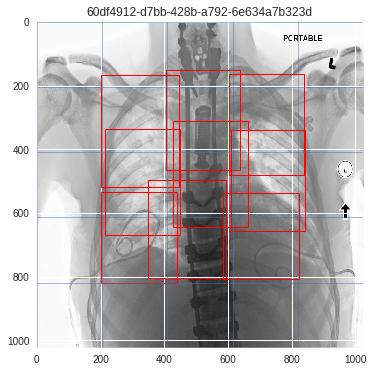

Truth: 2 2 349 461 139 195
Truth: 2 3 643 389 130 187
Pred: 1 1 conf: 0.87096566 215 186 245 342
Pred: 1 2 conf: 0.87678224 393 157 235 318
Pred: 1 3 conf: 0.8266335 580 173 238 317
Pred: 2 1 conf: 0.9490538 234 348 239 334
Pred: 2 2 conf: 0.95242065 364 297 244 330
Pred: 2 3 conf: 0.9302266 603 337 235 313
Pred: 3 1 conf: 0.8197061 247 566 223 283
Pred: 3 2 conf: 0.8864565 327 492 247 302
Pred: 3 3 conf: 0.8635922 577 532 240 275
True: 51415 Pred: 550129.5373778939 Intersect: 129047.0
IOU: 0.27311676737167356
Map IOU: 0.0


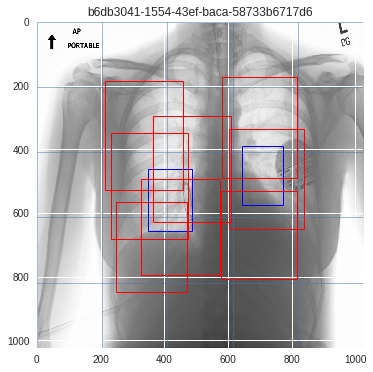

Pred: 1 1 conf: 0.91932905 196 182 251 364
Pred: 2 1 conf: 0.97204167 201 344 242 357
Pred: 2 2 conf: 0.9220704 356 309 241 315
Pred: 2 3 conf: 0.9553115 619 369 250 372
Pred: 3 1 conf: 0.9563981 206 524 239 314
Pred: 3 2 conf: 0.7976796 336 487 245 320
Pred: 3 3 conf: 0.95414835 637 540 235 326
True: 0 Pred: 302825.55066621304 Intersect: 0
IOU: 0.0
Map IOU: 0


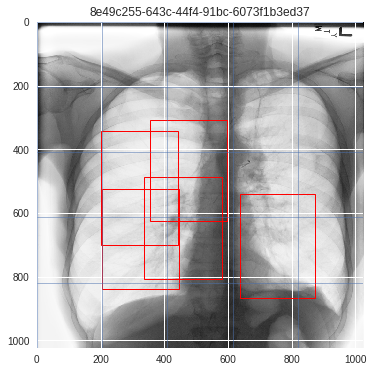

Truth: 2 3 564 400 215 245
Pred: 1 1 conf: 0.8089261 186 185 237 315
Pred: 2 1 conf: 0.9485352 211 341 233 322
Pred: 2 2 conf: 0.9381693 420 352 237 328
Pred: 2 3 conf: 0.88165355 605 365 234 309
Pred: 3 1 conf: 0.9298661 177 520 242 295
Pred: 3 2 conf: 0.9269724 402 523 240 301
Pred: 3 3 conf: 0.8998542 583 530 239 284
True: 52675 Pred: 350466.45302182436 Intersect: 97471.0
IOU: 0.3188760936364427
Map IOU: 0.05357142857142857


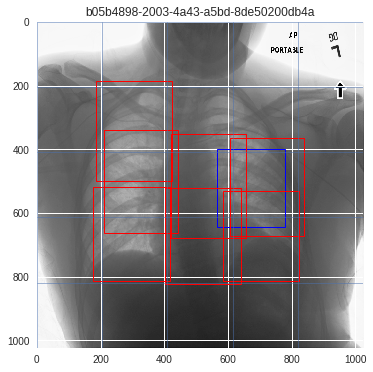

Pred: 1 1 conf: 0.96179426 196 165 251 376
Pred: 1 2 conf: 0.8744461 423 145 235 333
Pred: 1 3 conf: 0.8751223 580 165 238 322
Pred: 2 1 conf: 0.97310954 216 331 235 341
Pred: 2 2 conf: 0.91961104 466 313 230 365
Pred: 2 3 conf: 0.9457606 587 330 236 322
Pred: 3 1 conf: 0.94022727 180 516 244 290
Pred: 3 2 conf: 0.8216191 404 499 241 329
Pred: 3 3 conf: 0.9015972 571 523 243 277
True: 0 Pred: 494889.69354104996 Intersect: 0
IOU: 0.0
Map IOU: 0


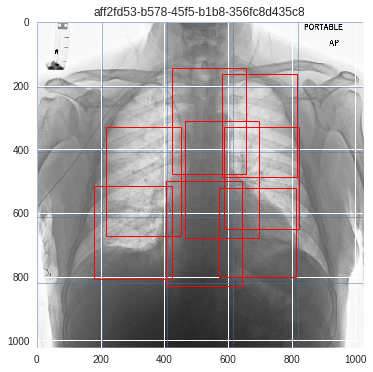

Pred: 1 1 conf: 0.9310411 194 164 241 337
Pred: 1 2 conf: 0.9073325 403 173 242 337
Pred: 1 3 conf: 0.7655014 596 184 233 300
Pred: 2 1 conf: 0.95762 203 328 237 321
Pred: 2 2 conf: 0.9576062 435 341 238 336
Pred: 2 3 conf: 0.9344727 608 343 233 316
Pred: 3 1 conf: 0.92757523 163 517 243 290
Pred: 3 2 conf: 0.93088305 416 526 239 304
Pred: 3 3 conf: 0.91980565 576 523 242 286
True: 0 Pred: 444011.5897487402 Intersect: 0
IOU: 0.0
Map IOU: 0


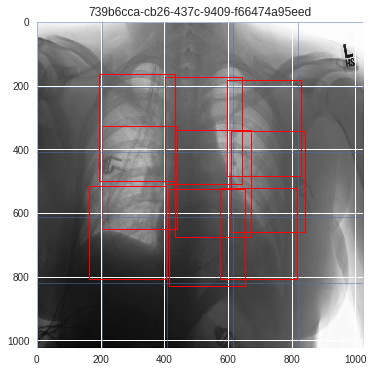

Pred: 1 1 conf: 0.8955152 198 176 244 340
Pred: 2 1 conf: 0.9537998 217 338 234 327
Pred: 2 3 conf: 0.8628114 609 353 232 295
Pred: 3 1 conf: 0.89018077 198 535 238 285
Pred: 3 3 conf: 0.83076614 610 554 232 277
True: 0 Pred: 282026.1711064577 Intersect: 0
IOU: 0.0
Map IOU: 0


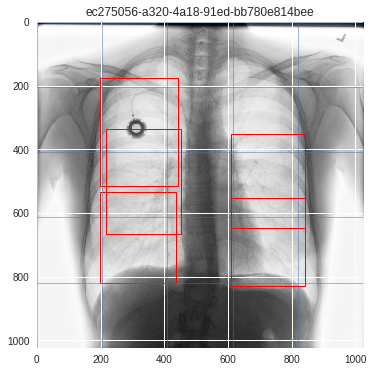

Pred: 1 1 conf: 0.8652845 166 168 239 325
Pred: 1 3 conf: 0.81938875 568 156 232 313
Pred: 2 1 conf: 0.9374352 165 325 237 312
Pred: 2 2 conf: 0.9452059 475 345 237 387
Pred: 2 3 conf: 0.9217912 552 326 237 313
Pred: 3 1 conf: 0.8172913 113 511 246 263
Pred: 3 2 conf: 0.7997491 458 541 227 322
Pred: 3 3 conf: 0.855134 535 518 246 263
True: 0 Pred: 200613.4769886732 Intersect: 0
IOU: 0.0
Map IOU: 0


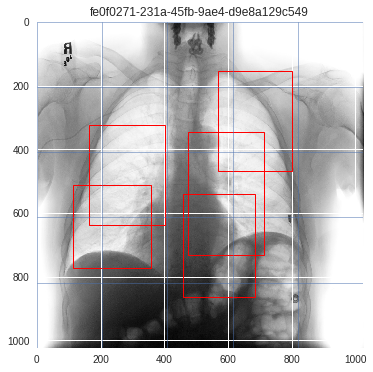

Truth: 1 1 216 289 133 146
Pred: 1 1 conf: 0.955057 191 148 240 344
Pred: 1 2 conf: 0.94524306 440 158 244 358
Pred: 1 3 conf: 0.89701605 581 150 232 312
Pred: 2 1 conf: 0.9529556 185 316 240 310
Pred: 2 2 conf: 0.95910305 464 327 234 360
Pred: 2 3 conf: 0.9370172 570 322 238 314
Pred: 3 1 conf: 0.9238835 165 519 243 286
Pred: 3 2 conf: 0.924903 412 523 240 306
Pred: 3 3 conf: 0.8985525 563 523 243 276
True: 19418 Pred: 373345.9781856537 Intersect: 15827.0
IOU: 0.041988451427980356
Map IOU: 0.0


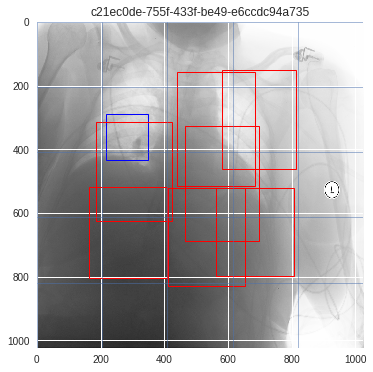

Pred: 1 1 conf: 0.9358579 184 164 246 354
Pred: 1 3 conf: 0.88740194 564 150 233 320
Pred: 2 1 conf: 0.9606237 190 316 240 316
Pred: 2 2 conf: 0.8388715 472 312 228 365
Pred: 2 3 conf: 0.92452866 575 321 239 302
Pred: 3 3 conf: 0.7730337 589 545 235 252
True: 0 Pred: 253722.44570070505 Intersect: 0
IOU: 0.0
Map IOU: 0


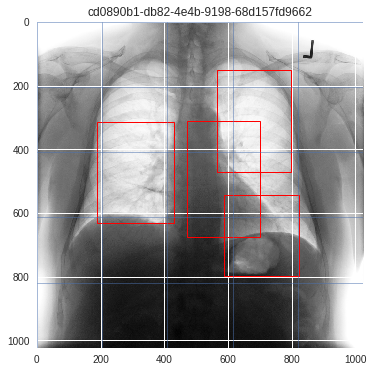

Pred: 1 1 conf: 0.80153185 197 185 235 308
Pred: 1 3 conf: 0.8120298 578 170 237 315
Pred: 2 1 conf: 0.91795343 211 349 233 314
Pred: 2 2 conf: 0.80041397 445 319 230 339
Pred: 2 3 conf: 0.93183297 597 341 233 318
Pred: 3 1 conf: 0.89567775 190 535 238 288
Pred: 3 3 conf: 0.9084224 586 527 240 289
True: 0 Pred: 389405.22283798456 Intersect: 0
IOU: 0.0
Map IOU: 0


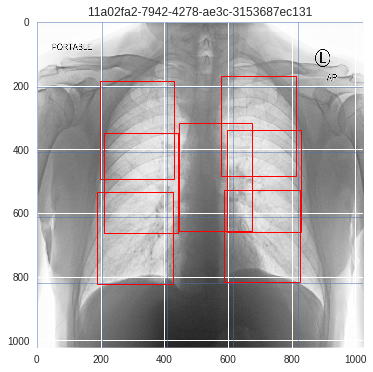

Overall Mean IOU: 0.16799512452112886
Overall Map IOU: 0.0041269841269841265


In [28]:
THRESHOLD = 0.75
OVERLAP = 0.5
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=15, replace=False)
# samples = problem_names

coords = np.arange(0, 1024, CELL_SIZE)
overall_ious = []
map_ious = []

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    
    # initialize our lists
    ious = []
    truths = []
    boxes = []
    
    # draw the truth boxes
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename].copy()
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0.5:
                    x, y, w, h = pixel_data[1:]
                    
                    # unnormalize the data
                    w = w * 1024
                    h = h * 1024
                    
                    x = unnorm(x, j, CELL_SIZE)
                    y = unnorm(y, i, CELL_SIZE)
                    
                    # get the corners
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    locs[i,j,:] = [1, x, y, w, h]
                    print("Truth:", i, j, x, y, w, h)
                    truths.append([x, y, w, h])
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
                    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    yhat = sigmoid(yhat)
    conf = np.squeeze(yhat)[:,:,0]
    bboxes = np.squeeze(yhat)[:,:,1:]    
    pred_boxes = np.zeros_like(bboxes)

    # loop through our predictions
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            conf_ = conf[i,j]
            # if we have a prediction
            if conf_ > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                
                # unnormalize the data
                w = w * 1024
                h = h * 1024

                x = unnorm(x, j, CELL_SIZE)
                y = unnorm(y, i, CELL_SIZE)
                
                # convert to upper left corner from center
                x = np.maximum(x - (w // 2), 0)
                y = np.maximum(y - (h // 2), 0)
                
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                
                pred_boxes[i,j,:] = [x, y, w, h]
                
                print("Pred:", i, j, "conf:", conf_, x, y, w, h)
                
                # if the boxes have width and height add them to our list
                if w > 30 and h > 30:
                    boxes.append([x,y,w,h, conf_])
    
    ## if we have ground truths OR predictions calculate the IOUs:
    if len(boxes) or len(truths):
        # do non-max suppression of our boxes
        nms_boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)

        # only count the IOU if there are either ground truths or predictions
        if len(nms_boxes) or len(truths):
            iou = calc_iou_better(np.array(truths), np.array(nms_boxes))
            print("IOU post-nms:", iou)
            overall_ious.append(iou)

        # plot our boxes
        for box in nms_boxes:
            x,y,w,h,c = box
            rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        if len(nms_boxes):
            scores = nms_boxes[...,4]
        else:
            scores = np.array([])

        map_iou_score = map_iou(np.array(truths), np.array(nms_boxes), scores)

        if map_iou_score is not None:
            map_ious.append(map_iou_score)

        for item in coords:
            plt.axvline(item, linewidth=0.5)
            plt.axhline(item, linewidth=0.5)

        print("IOU:", iou)
        print("Map IOU:", map_iou_score)
    
    plt.title(filename)
    plt.show()
    
print("Overall Mean IOU:", np.mean(overall_ious))    
print("Overall Map IOU:", np.mean(map_ious))    

# Predict test images

In [0]:
THRESHOLD = 0.75

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=24, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    yhats = model.predict(imgs)
    
    # apply sigmoid
    yhats = sigmoid(yhats)
    
    # loop through batch
    for yhat, filename in zip(yhats, filenames):
        predictionString = ""
        boxes = []
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                conf = yhat[i, j, 0]
                if conf > THRESHOLD:
                    x, y, w, h = yhat[i,j, 1:]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        w = w * 1024
                        h = h * 1024

                        x = unnorm(x, j, CELL_SIZE)
                        y = unnorm(y, i, CELL_SIZE)

                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            
            x = int(x)
            y = int(y)
            w = int(w)
            h = int(h)
        
            # create the prediction string
            predictionString += str(0.9) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

In [0]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f {submission_file} -m "YOLOv18.1 480x480 20 epochs"

In [27]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/

Updated property [core/project].
Copying file://./yolo18_1_480.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/54.6 MiB.                                     
